In [9]:
import os
import csv
import time
import platform
import datetime
import pandas as pd
import networkx as nx
from graph_partitioning import GraphPartitioning, utils

cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME", "MODULARITY", "LONELINESS", "NETWORK PERMANENCE", "NORM. MUTUAL INFO"]
pwd = %pwd


# parametrized config
parametrized_config = {
    "DATA_FILENAME": os.path.join(pwd, "data", "predition_model_tests", "network", "network_#networkID#.txt"),
    "OUTPUT_DIRECTORY": os.path.join(pwd, "output"),

    # Set which algorithm is run for the PREDICTION MODEL.
    # Either: 'FENNEL' or 'SCOTCH'
    "PREDICTION_MODEL_ALGORITHM": "",

    # Alternativly, read input file for prediction model.
    # Set to empty to generate prediction model using algorithm value above.
    "PREDICTION_MODEL": "",

    
    "PARTITIONER_ALGORITHM": "",

    # File containing simulated arrivals. This is used in simulating nodes
    # arriving at the shelter. Nodes represented by line number; value of
    # 1 represents a node as arrived; value of 0 represents the node as not
    # arrived or needing a shelter.
    "SIMULATED_ARRIVAL_FILE": os.path.join(pwd,
                                           "data",
                                           "predition_model_tests",
                                           "dataset_1_shift_rotate",
                                           "simulated_arrival_list",
                                           "percentage_of_prediction_correct_#correctedness#",
                                           "arrival_#correctedness#_#networkID#.txt"
                                          ),
    
    # File containing the prediction of a node arriving. This is different to the
    # simulated arrivals, the values in this file are known before the disaster.
    "PREDICTION_LIST_FILE": os.path.join(pwd,
                                         "data",
                                         "predition_model_tests",
                                         "dataset_1_shift_rotate",
                                         "prediction_list",
                                         "prediction_#networkID#.txt"
                                        ),

    # File containing the geographic location of each node, in "x,y" format.
    "POPULATION_LOCATION_FILE": os.path.join(pwd,
                                             "data",
                                             "predition_model_tests",
                                             "coordinates",
                                             "coordinates_#networkID#.txt"
                                            ),

    # Number of shelters
    "num_partitions": 6,

    # The number of iterations when making prediction model
    "num_iterations": 1,

    # Percentage of prediction model to use before discarding
    # When set to 0, prediction model is discarded, useful for one-shot
    "prediction_model_cut_off": 0.10,

    # Alpha value used in one-shot (when restream_batches set to 1)
    "one_shot_alpha": 0.5,

    # Number of arrivals to batch before recalculating alpha and restreaming.
    # When set to 1, one-shot is used with alpha value from above
    "restream_batches": 10,

    # When the batch size is reached: if set to True, each node is assigned
    # individually as first in first out. If set to False, the entire batch
    # is processed and empty before working on the next batch.
    "sliding_window": False,

    # Create virtual nodes based on prediction model
    "use_virtual_nodes": False,

    # Virtual nodes: edge weight
    "virtual_edge_weight": 1.0,

    # Loneliness score parameter. Used when scoring a partition by how many
    # lonely nodes exist.
    "loneliness_score_param": 1.2,

    ####
    # GRAPH MODIFICATION FUNCTIONS

    # Also enables the edge calculation function.
    "graph_modification_functions": True,

    # If set, the node weight is set to 100 if the node arrives at the shelter,
    # otherwise the node is removed from the graph.
    "alter_arrived_node_weight_to_100": False,

    # Uses generalized additive models from R to generate prediction of nodes not
    # arrived. This sets the node weight on unarrived nodes the the prediction
    # given by a GAM.
    # Needs POPULATION_LOCATION_FILE to be set.
    "alter_node_weight_to_gam_prediction": False,

    # The value of 'k' used in the GAM will be the number of nodes arrived until
    # it reaches this max value.
    "gam_k_value": 100,

    # Alter the edge weight for nodes that haven't arrived. This is a way to
    # de-emphasise the prediction model for the unknown nodes.
    "prediction_model_emphasis": 1.0,
    
    # This applies the prediction_list_file node weights onto the nodes in the graph
    # when the prediction model is being computed and then removes the weights
    # for the cutoff and batch arrival modes
    "apply_prediction_model_weights": True,
    
    # Path to the scotch shared library
    "SCOTCH_LIB_PATH": os.path.join(pwd, "libs/scotch/macOS/libscotch.dylib")
    if 'Darwin' in platform.system()
    else "/usr/local/lib/libscotch.so",
    
    # Path to the PaToH shared library
    "PATOH_LIB_PATH": os.path.join(pwd, "libs/patoh/lib/macOS/libpatoh.dylib")
    if 'Darwin' in platform.system()
    else os.path.join(pwd, "libs/patoh/lib/linux/libpatoh.so"),
    
    "PATOH_ITERATIONS": 5,

    # Alters how much information to print. Keep it at 1 for this notebook.
    # 0 - will print nothing, useful for batch operations.
    # 1 - prints basic information on assignments and operations.
    # 2 - prints more information as it batches arrivals.
    "verbose": 0
}

#gp = GraphPartitioning(config)

# Optional: shuffle the order of nodes arriving
# Arrival order should not be shuffled if using GAM to alter node weights
#random.shuffle(gp.arrival_order)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['partition']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [27]:
def getOutFileName(algorithm, partition, correctedness, cutoff, networkID, sliding, virtualNodes, gam):
    fn = algorithm + "_p" + str(partition) + "_c" + str(correctedness) + "_cutoff" + str(int(cutoff * 100))
    fn += "_sw" + str(int(sliding)) + "_vn" + str(int(virtualNodes)) + "_gam" + str(int(gam)) + "_" + str(networkID)
    return fn + ".txt"

def getConfig(parametrized_config, algorithm, partition, correctedness, cutoff, networkID, sliding, virtualNodes, gam):
    newConfig = parametrized_config.copy()
    for confKey in list(newConfig.keys()):
        changed = False
        conf = newConfig[confKey]
        try:
            if "#networkID#" in str(conf):
                conf = conf.replace("#networkID#", str(networkID))
                changed = True
            if "#correctedness#" in str(conf):
                conf = conf.replace("#correctedness#", str(correctedness))
                changed = True
        except Excpetion as err:
            pass
        if changed:
            newConfig[confKey] = conf
    newConfig["PREDICTION_MODEL_ALGORITHM"] = algorithm
    newConfig["PARTITIONER_ALGORITHM"] = algorithm
    newConfig["prediction_model_cut_off"] = cutoff
    newConfig["sliding_window"] = sliding
    newConfig["use_virtual_nodes"] = virtualNodes
    newConfig["alter_node_weight_to_gam_prediction"] = gam
    return newConfig

def experimentParentDir():
    return os.path.join(parametrized_config["OUTPUT_DIRECTORY"], datetime.datetime.now().strftime('%y_%m_%d').replace("/", ""))

def experimentDir():
    return os.path.join(experimentParentDir(), datetime.datetime.now().strftime('%H_%M_%S'))

def purgeEmptyDir(directory):
    for dirpath, dirnames, files in os.walk(directory):
        if not files:
            os.rmdir(directory)

def cutoffValueFunc(val):
    return val * 0.05

def times10(val):
    return val * 10

def fillRange(minN, maxN, valueFunc = None):
    values = []
    for p in range(minN, maxN):
        if valueFunc is None:
            values.append(p)
        else:
            values.append(valueFunc(p))
    return values

class OutFile:
    def __init__(self, filePath):
        self.contents = []
        self.filePath = filePath
    
    def write(self, moreContent):
        self.contents.append(moreContent)

    def save(self):
        with open(self.filePath, 'w+') as f:
            for content in self.contents:
                f.write(content)
                
    def load(self):
        predictionModelData = []
        batchModelData = []
        with open(self.filePath, 'r') as f:
            count = 1
            for line in f:
                line = line.strip()
                
                if(count == 45):
                    predictionModelData = self._convertCSVLineToFloat(line)

                if (count >= 121):
                    if 'ENDSTATS' in line:
                        break
                    batchModelData.append(self._convertCSVLineToFloat(line))                    
                count += 1
        return (predictionModelData, batchModelData)
    
    def _convertCSVLineToFloat(self, line):
        arr = []
        for part in line.split(", "):
            arr.append(float(part))
        return arr

def writeConfig(outFile, config, numPartitions, networkID):
    outFile.write("PREDICTION_MODEL_ALGORITHM = " + str(config["PREDICTION_MODEL_ALGORITHM"]) + "\n")
    outFile.write("PARTITIONER_ALGORITHM = " + str(config["PARTITIONER_ALGORITHM"]) + "\n")
    outFile.write("partitions = " + str(numPartitions) + "\n")
    outFile.write("networkID = " + str(networkID) + "\n")
    outFile.write("prediction_model_cut_off = " + str(config["prediction_model_cut_off"]) + "\n")
    outFile.write("sliding_window = " + str(config["sliding_window"]) + "\n")
    outFile.write("virtual_nodes = " + str(config["use_virtual_nodes"]) + "\n")
    outFile.write("gam = " + str(config["alter_node_weight_to_gam_prediction"]) + "\n")

def writeArray(outFile, arrayName, array, valuesPerLine = 50):
    outFile.write("\nSTARTARRAY-" + arrayName + "\n[")
    
    line = ""
    count = 0
    isFirst = True
    for value in array:
        if(len(line)):
            # add comma to separate from previous
            line += ", "
        # add new line if we've reached valuesPerLine
        if(count == valuesPerLine):
            count = 0;
            line += "\n"
        line += str(value)
        count += 1
    if len(line) > 0:
        outFile.write(line)
    outFile.write("]\nENDARRAY\n")

def writePartitionStats(outFile, section, gp, m):
    #print("writePartitionStats", outFile.contents)
    writeArray(outFile, section, gp.assignments)
    
    population = utils.get_partition_population(gp.G, gp.assignments, gp.num_partitions)

    outFile.write("\nSTARTSTATS FOR " + section + "\n")
    outFile.write("Partitions - nodes (weight)\n\n")
    for p in population:
        outFile.write("P{}: {} ({})\n".format(p, population[p][0], population[p][1]))

    # print dataframe stats now
    outFile.write("\nWASTE, CUT RATIO, EDGES CUT, TOTAL COMM VOLUME, MODULARITY, LONELINESS, NETWORK PERMANENCE, NORM. MUTUAL INFO\n\n")
    for row in m:
        line = ""
        for value in row:
            if len(line) > 0:
                line += ", "
            line += str(value)
        outFile.write(line + "\n")
    outFile.write("ENDSTATS\n")
    

def runPartitioning(config, outFilePath, numPartitions, networkID):
    start_time = time.time()
    
    gp = GraphPartitioning(config)
    
    outFile = OutFile(outFilePath)
    writeConfig(outFile, config, numPartitions, networkID)
    
    gp.load_network()
    gp.init_partitioner()
    
    m = gp.prediction_model()
    writePartitionStats(outFile, "prediction_model", gp, m)
        
    m = gp.assign_cut_off()
    writePartitionStats(outFile, "cutof", gp, m)

    m = gp.batch_arrival()
    writePartitionStats(outFile, "batch_arrivals", gp, m)
    
    outFile.write("Experiment duration = " + str(time.time() - start_time))
    outFile.save()
    
    del m
    del gp
    del outFile


In [11]:
# All possible ways to run the experiments
all_algorithms = ["FENNEL", "SCOTCH", "PATOH"]

all_correctedness = fillRange(0, 11, times10)
all_partitions = fillRange(4, 13)
all_networks = fillRange(1, 1001)
all_predictionModelCutoff = fillRange(0, 21, cutoffValueFunc)

storeResults = True

all_slidingWindow = [True, False]
all_virtualNodes = [True, False]
all_GAMModel = [True, False]

In [12]:
# EXPERIMENT 1: how does changing the cutoff on prediction model, alter how well partitions can be made

# todo avoid double experiments, cutoff, size of batch
# todo check edgescut = subset of population

# pick a subset of settings, if needed
algorithms = all_algorithms
partitions = [4, 6, 8]
correctedness = [100]
predictionModelCutoff = [0.2]
networks = [1]
slidingWindows = [False]
virtualNodes = [False]
GAMModels = [False]

outputDir = experimentDir()
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

experimentCount = 0
experimentTimes = []

dontRunExperiments = False # safety net to avoid overwriting experiments
for algorithm in algorithms:
    # run the experiment separately for each algorithm
    if dontRunExperiments == True:
        break
        
    for partition in partitions:
        # run the experiment with differnt number of partitions
        for correct in correctedness:
            # run the experiment for different correctedness predictions
            for cutoff in predictionModelCutoff:
                # this is the real experiment - different cutoff values
                for network in networks:
                    # sliding window
                    for sliding in slidingWindows:
                        # virtual nodes
                        for virtualNode in virtualNodes:
                            # GAM
                            for GAMModel in GAMModels:
                                start_time = time.time()

                                # setup the experiment
                                config = getConfig(parametrized_config, algorithm, partition, correct, cutoff, network, sliding, virtualNode, GAMModel)

                                outFN = getOutFileName(algorithm, partition, correct, cutoff, network, sliding, virtualNode, GAMModel)
                                outfPath = os.path.join(outputDir, outFN)
                                #with open(outfPath, 'w+') as experimentFile:
                                    # run experiment and store results
                                runPartitioning(config, outfPath, partition, network)
                                
                                elapsed_time = time.time() - start_time
                                print("Experiment", experimentCount, elapsed_time, outFN)
                                experimentTimes.append(elapsed_time)
                                experimentCount += 1

purgeEmptyDir(outputDir)

Experiment 0 2.8289918899536133 FENNEL_p4_c100_cutoff20_sw0_vn0_gam0_1.txt
Experiment 1 2.700352907180786 FENNEL_p6_c100_cutoff20_sw0_vn0_gam0_1.txt
Experiment 2 2.7480249404907227 FENNEL_p8_c100_cutoff20_sw0_vn0_gam0_1.txt
Experiment 3 8.34409785270691 SCOTCH_p4_c100_cutoff20_sw0_vn0_gam0_1.txt
Experiment 4 8.833292007446289 SCOTCH_p6_c100_cutoff20_sw0_vn0_gam0_1.txt
Experiment 5 8.552628993988037 SCOTCH_p8_c100_cutoff20_sw0_vn0_gam0_1.txt
Experiment 6 3.474442958831787 PATOH_p4_c100_cutoff20_sw0_vn0_gam0_1.txt
Experiment 7 3.3962831497192383 PATOH_p6_c100_cutoff20_sw0_vn0_gam0_1.txt
Experiment 8 3.342679023742676 PATOH_p8_c100_cutoff20_sw0_vn0_gam0_1.txt


FENNEL_p4_c100_cutoff20_sw0_vn0_gam0_1.txt
       WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  MODULARITY  LONELINESS  \
1   0.181818   0.054054        2.0                4.0    0.298854    0.361174   
2   0.263158   0.078431        4.0                8.0    0.315227    0.400102   
3   0.116279   0.083333        5.0               10.0    0.495939    0.424244   
4   0.125000   0.095890        7.0               14.0    0.525780    0.435676   
5   0.132075   0.100000        9.0               17.0    0.524281    0.452656   
6   0.189655   0.095238       10.0               19.0    0.545082    0.486901   
7   0.190476   0.100000       13.0               23.0    0.628035    0.545431   
8   0.191176   0.105263       16.0               26.0    0.625723    0.563475   
9   0.191781   0.096970       16.0               26.0    0.651305    0.580389   
10  0.192308   0.111111       21.0               35.0    0.655090    0.597300   
11  0.120482   0.122549       25.0               42.0    0.678310 

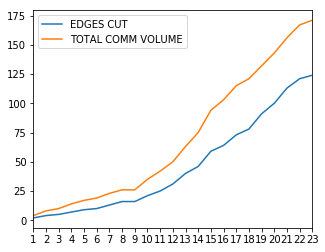

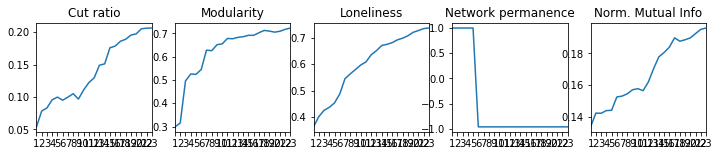

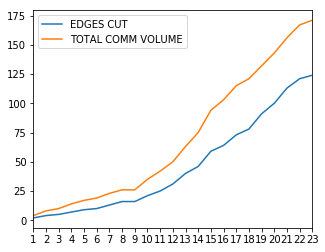

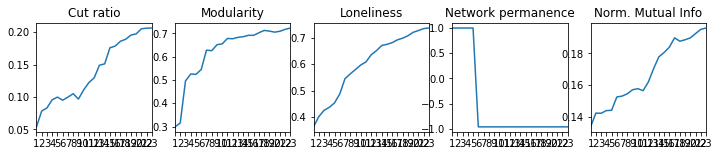

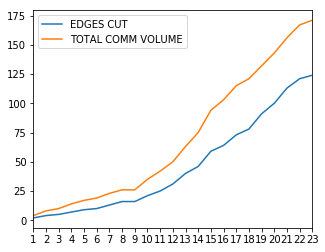

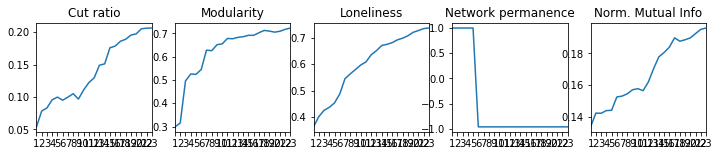

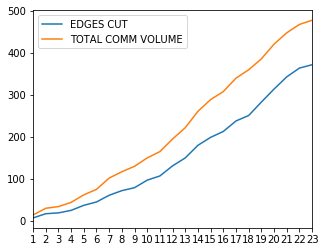

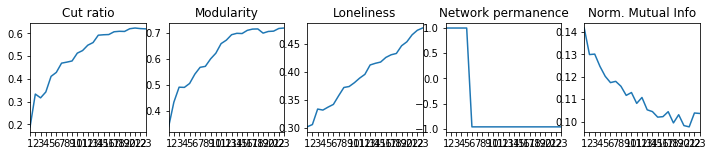

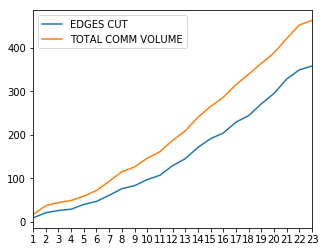

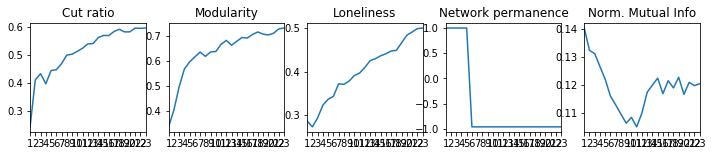

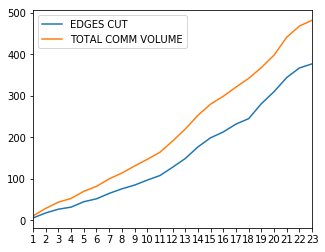

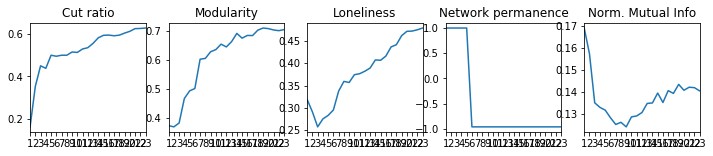

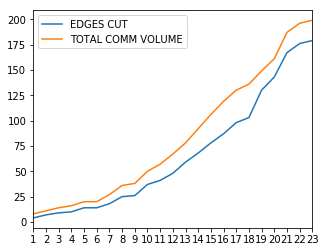

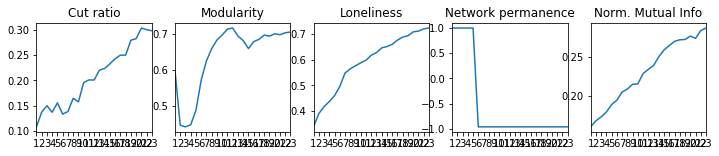

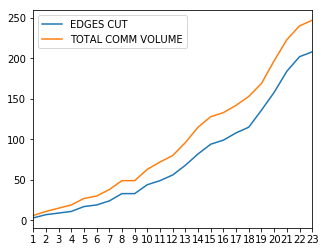

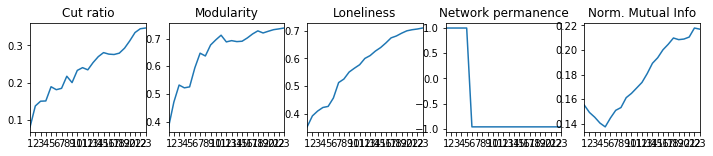

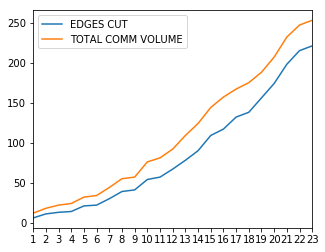

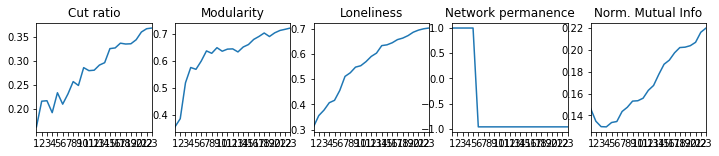

In [34]:
# analyse some experiments
resultsDir = os.path.join(parametrized_config['OUTPUT_DIRECTORY'], "17_04_05", "17_33_54")

algorithms = all_algorithms
partitions = [4, 6, 8]
correctedness = [100]
predictionModelCutoff = [0.2]
networks = [1]
slidingWindows = [False]
virtualNodes = [False]
GAMModels = [False]

class ExperimentData:
    def __init__(self, name, path, algorithm, partitions, correctedness, cutoff, networkID, slidingWindow, virtualNodes, GAMModel):
        self.experimentName = name
        self.experimentPath = path
        
        self.algorithm = algorithm
        self.partitions = partitions
        self.correctedness = correctedness
        self.cutoff = cutoff
        self.networkID = networkID
        self.slidingWindow = slidingWindow
        self.virtualNodes = virtualNodes
        self.gamModel = GAMModel
        
        self.predictionModelMetrics = []
        self.batchMetrics = []

        
# load the expected experiments
for algorithm in algorithms:
    # run the experiment separately for each algorithm        
    experiments = []
    for partition in partitions:
        # run the experiment with differnt number of partitions
        for correct in correctedness:
            # run the experiment for different correctedness predictions
            for cutoff in predictionModelCutoff:
                # this is the real experiment - different cutoff values
                for network in networks:
                    # sliding window
                    for sliding in slidingWindows:
                        # virtual nodes
                        for virtualNode in virtualNodes:
                            # GAM
                            for GAMModel in GAMModels:
                                outFN = getOutFileName(algorithm, partition, correct, cutoff, network, sliding, virtualNode, GAMModel)
                                outfPath = os.path.join(outputDir, outFN)

                                experiment = ExperimentData(outFN, outfPath, algorithm, partition, correct, cutoff, network, sliding, virtualNode, GAMModel)
                                
                                outFile = OutFile(outfPath)
                                data = outFile.load()
                                experiment.predictionModelMetrics = data[0]
                                experiment.batchMetrics = data[1]
                                
                                experiments.append(experiment)

    for experiment in experiments:
        # test the impact of number of partitions on metrics
        print(experiment.experimentName)
        
        rows = list(range(1, len(experiment.batchMetrics)+1))
        df = pd.DataFrame(experiment.batchMetrics, index=rows, columns=cols).astype(float)
        print(df)

        print(len(df))
        
        if len(df) > 1:
            df.plot(y=['EDGES CUT', 'TOTAL COMM VOLUME'], xticks=rows, figsize=(5,4))

            fig, axs = plt.subplots(1,5)
            df.plot(y=['CUT RATIO'], title='Cut ratio', xticks=rows, figsize=(12,2), legend=False, ax=axs[0])
            df.plot(y=['MODULARITY'], title='Modularity', xticks=rows, figsize=(12,2), legend=False, ax=axs[1])
            df.plot(y=['LONELINESS'], title='Loneliness', xticks=rows, figsize=(12,2), legend=False, ax=axs[2])
            df.plot(y=['NETWORK PERMANENCE'], title='Network permanence', xticks=rows, figsize=(12,2), legend=False, ax=axs[3])
            df.plot(y=['NORM. MUTUAL INFO'], title='Norm. Mutual Info', xticks=rows, figsize=(12,2), legend=False, ax=axs[4])

        else:
            print("\n\nNot enough data points to plot charts. There is only one row.")